<a href="https://colab.research.google.com/github/parita2003/Warehouse_Stock_Prediction/blob/main/Copy_of_prediction_model_using_GBR_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats
import joblib

In [4]:
# Load the dataset
df = pd.read_csv('test3 (3).csv')
df_original = df.copy()
df1=pd.read_csv("current.csv")
num_distinct_values = df["Category"].nunique()
Capacity_sum = sum(df["Capacity"])/len(df["Capacity"])
Amt_avai_sum = sum(df1["Amt_avai"])/len(df1["Amt_avai"])
percent = Amt_avai_sum/Capacity_sum
df

,Item_ID,Item_Name,Category,Date,Last_Month_Sales,Capacity,Last_Year_Sales,Temperature,Weather,Predicted_sales
0,13,Peach,Fruits,12-21-2019,82,109,77,33,Autumn,81
1,15,Lemon,Fruits,9-29-2023,71,99,68,32,Winter,68
2,11,Cherry,Fruits,11-04-2022,71,99,68,38,Sunny,68
3,27,Potato,Vegetables,02-07-2021,82,109,77,48,Autumn,78
4,40,Green Bean,Vegetables,09-11-2021,82,109,77,36,Autumn,78
...,...,...,...,...,...,...,...,...,...,...
2994,32,Bell Pepper,Vegetables,11-02-2022,82,99,68,46,Autumn,69
2995,43,Radish,Vegetables,12-06-2019,90,99,68,40,Sunny,70
2996,40,Green Bean,Vegetables,7-26-2019,71,99,68,33,Rainy,70
2997,45,Brussels Sprout,Vegetables,01-01-2023,23,99,68,50,Autumn,68


In [5]:
# Keeping the Item_ID for later use
item_ids = df['Item_ID'].values

In [6]:
# One-hot encoding
categorical_cols = ['Item_Name', 'Category', 'Weather']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [7]:
# The target variable is the actual sales values
y = df['Predicted_sales'].values
df.drop(columns=['Item_ID', 'Date', 'Predicted_sales'], inplace=True)

In [8]:
X = df.values

In [9]:
# Scaling the features
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

In [10]:
# Scaling the target
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

In [11]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=0)
gbr.fit(X_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=500,
                          random_state=0)

In [13]:
joblib.dump(gbr, "gbr_model.pkl")
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']

In [14]:
# Predict on validation set for Gradient Boosting Regressor
y_val_pred_gbr = gbr.predict(X_val)


In [15]:
# Calculate evaluation metrics for Gradient Boosting Regressor
mae_gbr = mean_absolute_error(y_val, y_val_pred_gbr)
mse_gbr = mean_squared_error(y_val, y_val_pred_gbr)
r2_gbr = r2_score(y_val, y_val_pred_gbr)


In [16]:
print("Gradient Boosting Regressor Metrics:")
print("Mean Absolute Error (MAE):", mae_gbr)
print("Mean Squared Error (MSE):", mse_gbr)
print("R^2 Score:", r2_gbr)

Gradient Boosting Regressor Metrics:
Mean Absolute Error (MAE): 0.012119512272567447
Mean Squared Error (MSE): 0.00022764658363523348
R^2 Score: 0.9806707072976087


In [17]:
# Define a threshold (e.g., 5%)
threshold = 0.05

# Calculate the number of predictions within the threshold
within_threshold = np.sum(np.abs(y_val - y_val_pred_gbr.reshape(-1, 1)) <= threshold * y_val)

# Calculate the accuracy-like metric
accuracy_like_metric = within_threshold / len(y_val)

print("Accuracy-like Metric (within 5% threshold):", accuracy_like_metric)


Accuracy-like Metric (within 5% threshold): 0.9883333333333333


In [18]:
def plot_predictions_vs_actual(y_true, y_pred):
    plt.figure(figsize=(12, 5))

    # Actual vs Predicted Sales
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title('Actual vs. Predicted Sales')

    # Residuals vs Predicted Values
    residuals = y_true.ravel() - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.hlines(0, min(y_pred), max(y_pred), colors='k', linestyles='--')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted Sales')

    plt.tight_layout()
    plt.show()

In [19]:
def plot_accuracy_over_thresholds(y_true, y_pred):
    thresholds = np.linspace(0, 0.5, 50)  # Varying thresholds from 0 to 50%
    accuracies = []

    for threshold in thresholds:
        within_threshold = np.sum(np.abs(y_true - y_pred.reshape(-1, 1)) <= threshold * y_true)
        accuracy = within_threshold / len(y_true)
        accuracies.append(accuracy)

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, accuracies, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy-like Metric')
    plt.title('Model Accuracy-like Metric over Varying Thresholds')
    plt.grid(True)
    plt.show()

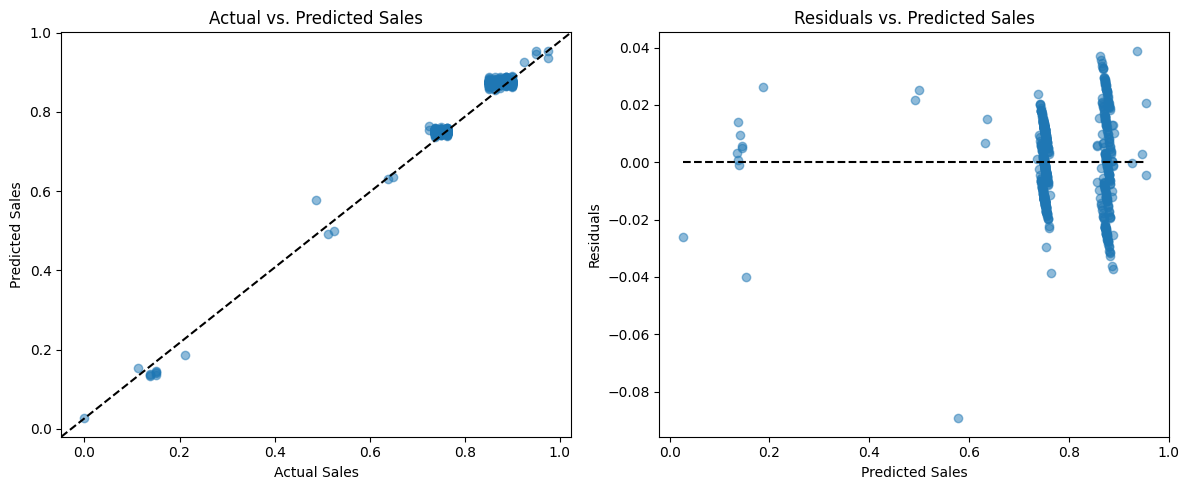

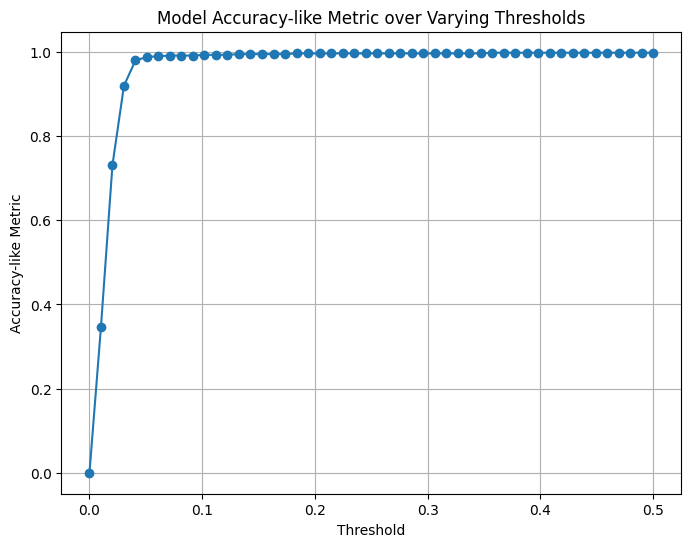

In [20]:
plot_predictions_vs_actual(y_val, y_val_pred_gbr)
plot_accuracy_over_thresholds(y_val, y_val_pred_gbr)

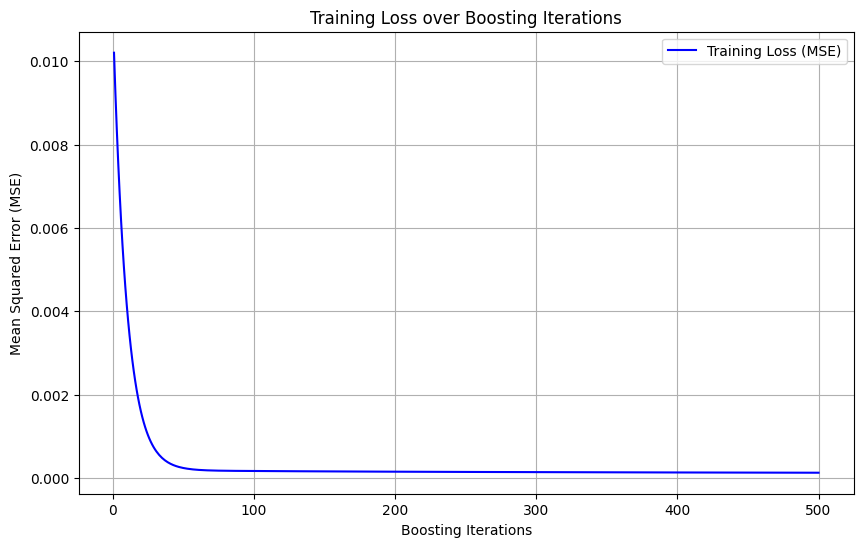

In [21]:
# Calculate training loss (Mean Squared Error) over each boosting iteration
train_loss = [mean_squared_error(y_train, y_pred) for y_pred in gbr.staged_predict(X_train)]
iterations = np.arange(len(train_loss)) + 1

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_loss, '-b', label='Training Loss (MSE)')
plt.xlabel('Boosting Iterations')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Loss over Boosting Iterations')
plt.legend()
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Actual vs. Predicted Sales')

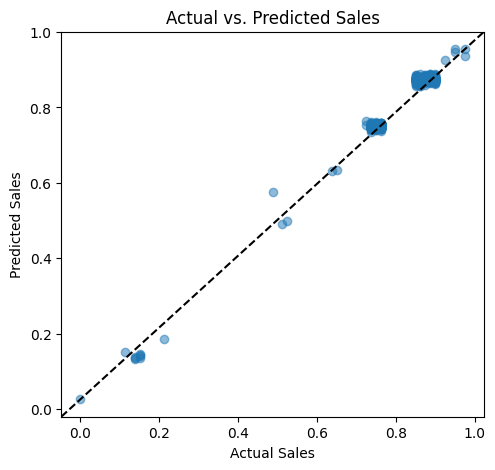

In [22]:
# 1. Scatter Plot (Actual vs. Predicted)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_val_pred_gbr, alpha=0.5)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs. Predicted Sales')

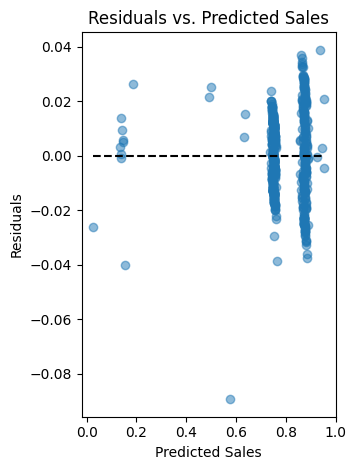

In [23]:
# 2. Residuals Plot
residuals = y_val.ravel() - y_val_pred_gbr
plt.subplot(1, 2, 2)
plt.scatter(y_val_pred_gbr, residuals, alpha=0.5)
plt.hlines(0, min(y_val_pred_gbr), max(y_val_pred_gbr), colors='k', linestyles='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Sales')
plt.tight_layout()
plt.show()

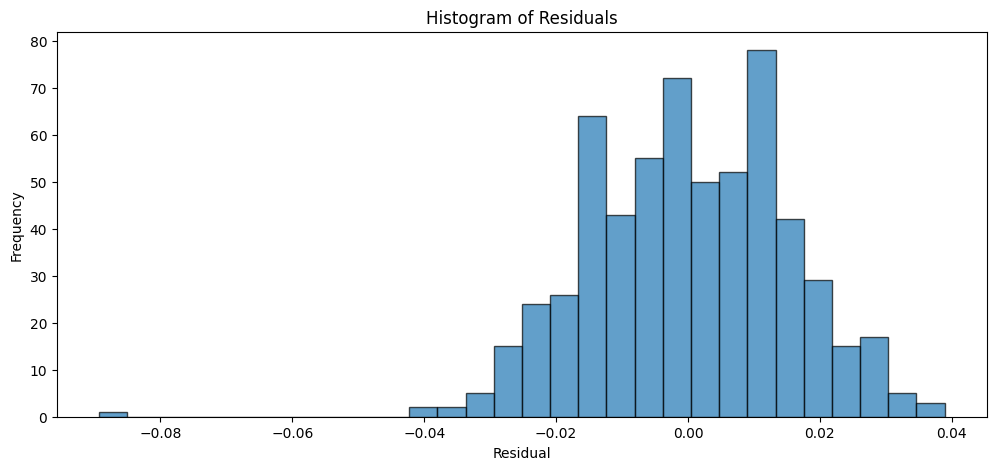

In [24]:
# 3. Histogram of Residuals
plt.figure(figsize=(12, 5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

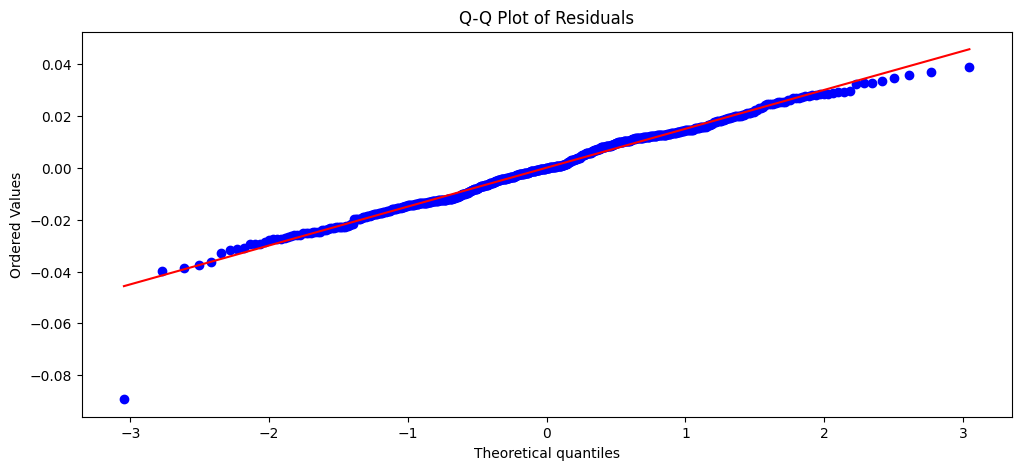

In [25]:
plt.figure(figsize=(12, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [26]:
# # print(predict_sales_for_item_gbr(int(input("Enter the item ID")),input("enter the available amount")))
# for i in range len(df1['Item_ID']:
#   item = int(input("Enter the item ID"))
#   Amount = float(input("enter the available amount"))
#   print(predict_sales_for_item_gbr(item, Amount))


In [27]:
df

,Last_Month_Sales,Capacity,Last_Year_Sales,Temperature,Item_Name_Artichoke,Item_Name_Asparagus,Item_Name_Avocado,Item_Name_Banana,Item_Name_Beets,Item_Name_Bell Pepper,...,Item_Name_Spinach,Item_Name_Strawberry,Item_Name_Sweet Potato,Item_Name_Tomato,Item_Name_Watermelon,Item_Name_Zucchini,Category_Vegetables,Weather_Rainy,Weather_Sunny,Weather_Winter
0,82,109,77,33,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,71,99,68,32,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,71,99,68,38,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,82,109,77,48,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,82,109,77,36,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,82,99,68,46,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
2995,90,99,68,40,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2996,71,99,68,33,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
2997,23,99,68,50,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [28]:
df1 = pd.read_csv("current.csv")

In [29]:
df1

,Item_ID,Item_Name,Amt_avai
0,13,Peach,13
1,15,Lemon,15
2,11,Cherry,11
3,27,Potato,27
4,40,Green Bean,40
5,42,Celery,42
6,5,Grape,5
7,4,Mango,4
8,44,Asparagus,44
9,14,Plum,14


In [30]:
No_of_item = len(df1['Item_ID'])
print(No_of_item)

50


In [31]:


# Print the number of distinct values
print("Number of distinct values in column '{}': {}".format("Category", num_distinct_values))

Number of distinct values in column 'Category': 2


In [32]:
print(Capacity_sum)

102.16372124041347


In [33]:
print(Capacity_sum)
print(Amt_avai_sum)
avai_perc = 100-percent*100
print(("The available capacity in the warehouse: "),avai_perc)

102.16372124041347
25.5
The available capacity in the warehouse:  75.04006344875306


In [34]:
Amt_abt_to_finish = min(df1['Amt_avai'])


if Amt_abt_to_finish in df1['Amt_avai'].values:
    # Get the index of the row where the value exists
    row_index = df1[df1['Amt_avai'] == Amt_abt_to_finish].index[0]
    print("Index of the row where {} exists in 'column1': {}".format(Amt_abt_to_finish, row_index))
    value_at_index = df1['Item_Name'].iloc[row_index]
    print(value_at_index)



Index of the row where 1 exists in 'column1': 34
Apple


In [35]:
# Function to analyze sentiment
import requests
from textblob import TextBlob

def analyze_sentiment(item_name):
    # News API endpoint
    url = ('https://newsapi.org/v2/everything?'
           'q={}&'
           'sortBy=popularity&'
           'apiKey=0d87bdd74dab48b6b8025a26cf249b36')

    # Make a request to the News API
    response = requests.get(url.format(item_name))

    # Parse the JSON response
    data = response.json()

    # Check if 'articles' key exists in the response
    if 'articles' not in data:
        return 0  # Return 0 if no articles found

    # Initialize variables for sentiment analysis
    total_sentiment = 0
    num_articles = 0

    for article in data['articles']:
        title = article.get('title')
        description = article.get('description')
        text = title + '. ' + description if description else title
        sentiment = TextBlob(text).sentiment.polarity
        total_sentiment += sentiment
        num_articles += 1
        if num_articles == 5:
            break

    # Calculate average sentiment
    if num_articles > 0:
        average_sentiment = total_sentiment / num_articles
    else:
        average_sentiment = 0

    return average_sentiment

# Apply sentiment analysis to each row in the DataFrame
df1['Sentiment'] = df1['Item_Name'].apply(analyze_sentiment)

# Display the updated DataFrame
print(df1)


    Item_ID        Item_Name  Amt_avai  Sentiment
0        13            Peach        13   0.053206
1        15            Lemon        15   0.213590
2        11           Cherry        11   0.225485
3        27           Potato        27   0.161879
4        40       Green Bean        40   0.049747
5        42           Celery        42   0.241794
6         5            Grape         5   0.082657
7         4            Mango         4   0.149444
8        44        Asparagus        44   0.196151
9        14             Plum        14   0.205000
10       38         Eggplant        38   0.232557
11       24          Avocado        24   0.458333
12        3           Orange         3   0.260688
13       36      Cauliflower        36   0.067121
14       26           Tomato        26   0.215333
15        7             Kiwi         7  -0.008182
16        6        Pineapple         6   0.340714
17       39          Pumpkin        39   0.142121
18       30          Spinach        30   0.183333


In [36]:
import joblib

# Initialize maximum predicted sales and associated product name
m = 0
demand = ""

def predict_sales_for_item_gbr(item_no, avail, df):
    global m, demand

    # Load the saved model and scalers
    loaded_gbr = joblib.load("gbr_model.pkl")
    loaded_scaler_X = joblib.load("scaler_X.pkl")
    loaded_scaler_y = joblib.load("scaler_y.pkl")

    # Check if item_no exists in the dataset
    if item_no not in df['Item_ID'].values:
        return f"Item number {item_no} does not exist."

    item_name = df[df['Item_ID'] == item_no]['Item_Name'].iloc[0]
    item_idx = df[df['Item_ID'] == item_no].index[0]
    latest_data = X[item_idx].reshape(1, -1)
    predicted_sales_scaled = loaded_gbr.predict(latest_data)
    predicted_sales = loaded_scaler_y.inverse_transform(predicted_sales_scaled.reshape(-1, 1))[0][0]
    sales_diff = predicted_sales - avail

    # Update maximum predicted sales and associated product name
    if predicted_sales > m:
        m = predicted_sales
        demand = item_name

    # Apply strategies to increase predicted sales and sales difference based on sentiment analysis
    sentiment = df[df['Item_ID'] == item_no]['Sentiment'].iloc[0]
    if sentiment > 0:  # Positive sentiment
        # Example strategy: Increase predicted sales by 10% for positive sentiment
        predicted_sales *= 1.10
    elif sentiment < 0:  # Negative sentiment
        # Example strategy: Decrease predicted sales by 5% for negative sentiment
        predicted_sales *= 0.95

    # Update sales difference based on the updated predicted sales
    sales_diff = predicted_sales - avail

    # Add predicted sales and sales difference to the dataset
    df.loc[df['Item_ID'] == item_no, 'Predicted_Sales'] = predicted_sales
    df.loc[df['Item_ID'] == item_no, 'Sales_Difference'] = sales_diff

    return df

# Iterate over all items in df1 and update the dataset
for i in range(len(df1['Item_ID'])):
    item = df1["Item_ID"].iloc[i]
    amount = df1["Amt_avai"].iloc[i]
    df1 = predict_sales_for_item_gbr(item, amount, df1)

df1.sort_values('Item_ID', ascending=True)
# Display the updated dataset
print(df1)

# Print maximum predicted sales and its associated product name
print("Maximum Predicted Sales:", m)
print("Product with Maximum Predicted Sales:", demand)


    Item_ID        Item_Name  Amt_avai  Sentiment  Predicted_Sales  \
0        13            Peach        13   0.053206        87.359478   
1        15            Lemon        15   0.213590        75.117523   
2        11           Cherry        11   0.225485        75.369140   
3        27           Potato        27   0.161879        86.859594   
4        40       Green Bean        40   0.049747        86.891809   
5        42           Celery        42   0.241794        88.289521   
6         5            Grape         5   0.082657        76.242578   
7         4            Mango         4   0.149444        75.886032   
8        44        Asparagus        44   0.196151        76.760305   
9        14             Plum        14   0.205000        22.597759   
10       38         Eggplant        38   0.232557        76.242085   
11       24          Avocado        24   0.458333        75.816382   
12        3           Orange         3   0.260688        87.002723   
13       36      Cau